In [1]:
# –ò–º–ø–æ—Ä—Ç –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö –±–∏–±–ª–∏–æ—Ç–µ–∫ –¥–ª—è –º–æ–¥–µ–ª–µ–π –∏ –º–µ—Ç—Ä–∏–∫
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                           classification_report, confusion_matrix, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np

# –§–∏–∫—Å–∞—Ü–∏—è random_state –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö, –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω—ã—Ö –£—á–∞—Å—Ç–Ω–∏–∫–æ–º 1
import pickle

with open('../data/interim/data_split.pkl', 'rb') as f:
    data_split = pickle.load(f)

X_train = data_split['X_train']
X_valid = data_split['X_valid']
X_test = data_split['X_test']
y_train = data_split['y_train']
y_valid = data_split['y_valid']
y_test = data_split['y_test']
feature_names = data_split['feature_names']
preprocessor = data_split['preprocessor']

print("–î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω—ã!")
print(f"–†–∞–∑–º–µ—Ä—ã –≤—ã–±–æ—Ä–æ–∫: Train {X_train.shape}, Valid {X_valid.shape}, Test {X_test.shape}")

–î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω—ã!
–†–∞–∑–º–µ—Ä—ã –≤—ã–±–æ—Ä–æ–∫: Train (460, 8), Valid (154, 8), Test (154, 8)


In [4]:
# –§—É–Ω–∫—Ü–∏–∏ –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –º–æ–¥–µ–ª–µ–π

def evaluate_model(model, X, y, model_name="Model"):
    """–ö–æ–º–ø–ª–µ–∫—Å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏"""
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)
    
    # –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    print(f"=== {model_name} ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return {
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def plot_metrics_comparison(metrics_dict):
    """–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –º–µ—Ç—Ä–∏–∫ –º–æ–¥–µ–ª–µ–π"""
    models = list(metrics_dict.keys())
    metrics = ['f1', 'roc_auc', 'pr_auc']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        values = [metrics_dict[model][metric] for model in models]
        axes[i].bar(models, values, color=['skyblue', 'lightcoral'])
        axes[i].set_title(f'{metric.upper()} Comparison')
        axes[i].set_ylabel(metric.upper())
        axes[i].set_ylim(0, 1)
        
        # –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π –Ω–∞ —Å—Ç–æ–ª–±—Ü—ã
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [5]:
from sklearn.pipeline import Pipeline

# –ú–æ–¥–µ–ª—å 1: Logistic Regression

# –°–æ–∑–¥–∞–Ω–∏–µ –∏ –æ–±—É—á–µ–Ω–∏–µ Logistic Regression
print("–û–±—É—á–µ–Ω–∏–µ Logistic Regression...")

# –°–æ–∑–¥–∞–Ω–∏–µ –ø–∞–π–ø–ª–∞–∏–Ω–∞ —Å –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–µ–π
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'  # –£—á–µ—Ç –¥–∏—Å–±–∞–ª–∞–Ω—Å–∞ –∫–ª–∞—Å—Å–æ–≤
    ))
])

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
lr_pipeline.fit(X_train, y_train)

# –û—Ü–µ–Ω–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
lr_metrics = evaluate_model(lr_pipeline, X_valid, y_valid, "Logistic Regression")

–û–±—É—á–µ–Ω–∏–µ Logistic Regression...
=== Logistic Regression ===
F1 Score: 0.6545
ROC-AUC: 0.8574
PR-AUC: 0.7436

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.64      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.75      0.75       154



In [6]:
# –ú–æ–¥–µ–ª—å 2: Decision Tree Classifier —Å –ø–æ–¥–±–æ—Ä–æ–º max_depth

# –ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ max_depth –¥–ª—è Decision Tree
print("–ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ max_depth –¥–ª—è Decision Tree...")

max_depths = [3, 5, 7, 10, 15, 20, None]
best_depth = None
best_f1 = 0
depth_results = []

for depth in max_depths:
    # –°–æ–∑–¥–∞–Ω–∏–µ –∏ –æ–±—É—á–µ–Ω–∏–µ –¥–µ—Ä–µ–≤–∞
    dt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=depth,
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ))
    ])
    
    dt_pipeline.fit(X_train, y_train)
    
    # –û—Ü–µ–Ω–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
    y_pred = dt_pipeline.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)
    depth_results.append((depth, f1))
    
    print(f"max_depth={depth}: F1 Score = {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print(f"\n–õ—É—á—à–∏–π max_depth: {best_depth} —Å F1 Score: {best_f1:.4f}")

–ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ max_depth –¥–ª—è Decision Tree...
max_depth=3: F1 Score = 0.7368
max_depth=5: F1 Score = 0.6949
max_depth=7: F1 Score = 0.6727
max_depth=10: F1 Score = 0.6972
max_depth=15: F1 Score = 0.6667
max_depth=20: F1 Score = 0.6667
max_depth=None: F1 Score = 0.6667

–õ—É—á—à–∏–π max_depth: 3 —Å F1 Score: 0.7368


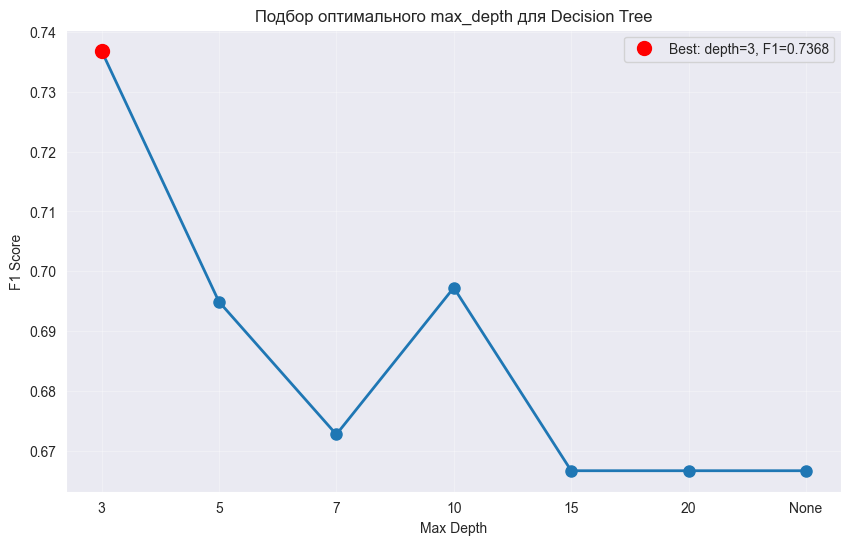

In [7]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ø–æ–¥–±–æ—Ä–∞ max_depth
depths = [str(d) if d is not None else 'None' for d in max_depths]
f1_scores = [result[1] for result in depth_results]

plt.figure(figsize=(10, 6))
plt.plot(depths, f1_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('–ü–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ max_depth –¥–ª—è Decision Tree')
plt.grid(True, alpha=0.3)

# –í—ã–¥–µ–ª–µ–Ω–∏–µ –ª—É—á—à–µ–≥–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
best_idx = depths.index(str(best_depth) if best_depth is not None else 'None')
plt.plot(depths[best_idx], f1_scores[best_idx], 'ro', markersize=10, label=f'Best: depth={best_depth}, F1={best_f1:.4f}')
plt.legend()
plt.show()

In [8]:
# –û–±—É—á–µ–Ω–∏–µ Decision Tree —Å –ª—É—á—à–∏–º max_depth
print(f"–û–±—É—á–µ–Ω–∏–µ Decision Tree —Å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–º max_depth={best_depth}...")

dt_best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=best_depth,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ))
])

dt_best_pipeline.fit(X_train, y_train)

# –û—Ü–µ–Ω–∫–∞ –ª—É—á—à–µ–π Decision Tree –º–æ–¥–µ–ª–∏
dt_metrics = evaluate_model(dt_best_pipeline, X_valid, y_valid, f"Decision Tree (max_depth={best_depth})")

–û–±—É—á–µ–Ω–∏–µ Decision Tree —Å –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–º max_depth=3...
=== Decision Tree (max_depth=3) ===
F1 Score: 0.7368
ROC-AUC: 0.8749
PR-AUC: 0.7436

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       100
           1       0.62      0.91      0.74        54

    accuracy                           0.77       154
   macro avg       0.78      0.80      0.77       154
weighted avg       0.82      0.77      0.78       154



In [10]:
import pandas as pd

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫ –æ–±–µ–∏—Ö –º–æ–¥–µ–ª–µ–π
print("–°–†–ê–í–ù–ï–ù–ò–ï –ë–ê–ó–û–í–´–• –ú–û–î–ï–õ–ï–ô")
print("=" * 50)

metrics_comparison = {
    'Logistic Regression': lr_metrics,
    f'Decision Tree (depth={best_depth})': dt_metrics
}

# –¢–∞–±–ª–∏—á–Ω–æ–µ —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ
comparison_df = pd.DataFrame({
    'Model': list(metrics_comparison.keys()),
    'F1 Score': [metrics_comparison[model]['f1'] for model in metrics_comparison],
    'ROC-AUC': [metrics_comparison[model]['roc_auc'] for model in metrics_comparison],
    'PR-AUC': [metrics_comparison[model]['pr_auc'] for model in metrics_comparison]
})

print(comparison_df.round(4))

–°–†–ê–í–ù–ï–ù–ò–ï –ë–ê–ó–û–í–´–• –ú–û–î–ï–õ–ï–ô
                     Model  F1 Score  ROC-AUC  PR-AUC
0      Logistic Regression    0.6545   0.8574  0.7436
1  Decision Tree (depth=3)    0.7368   0.8749  0.7436


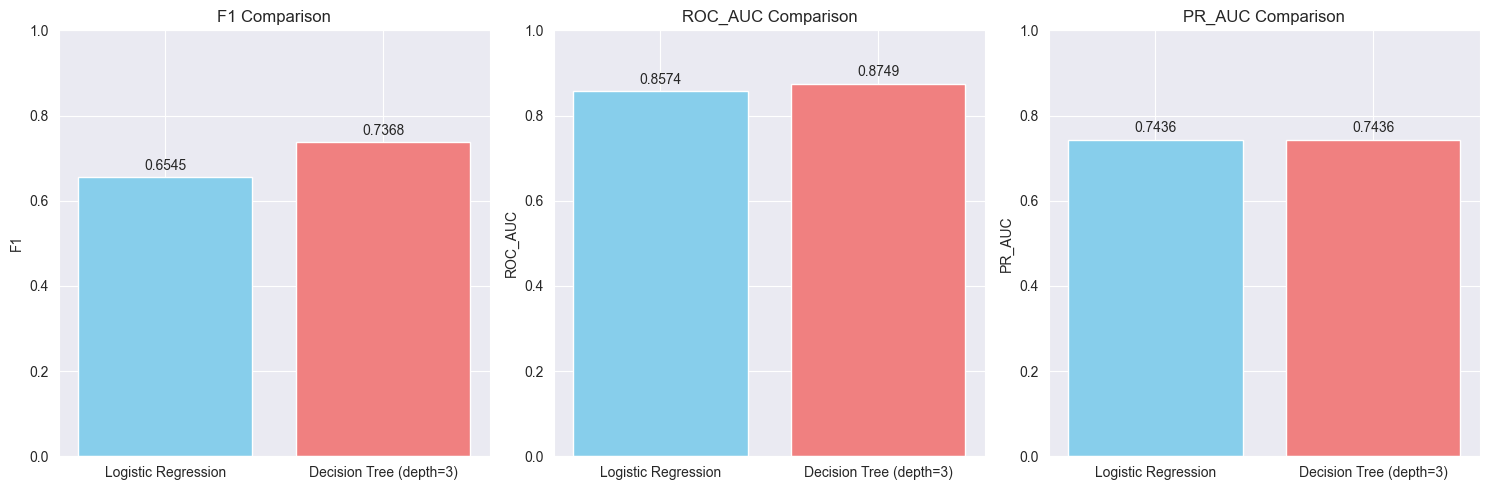

In [11]:
# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è –º–µ—Ç—Ä–∏–∫
plot_metrics_comparison(metrics_comparison)

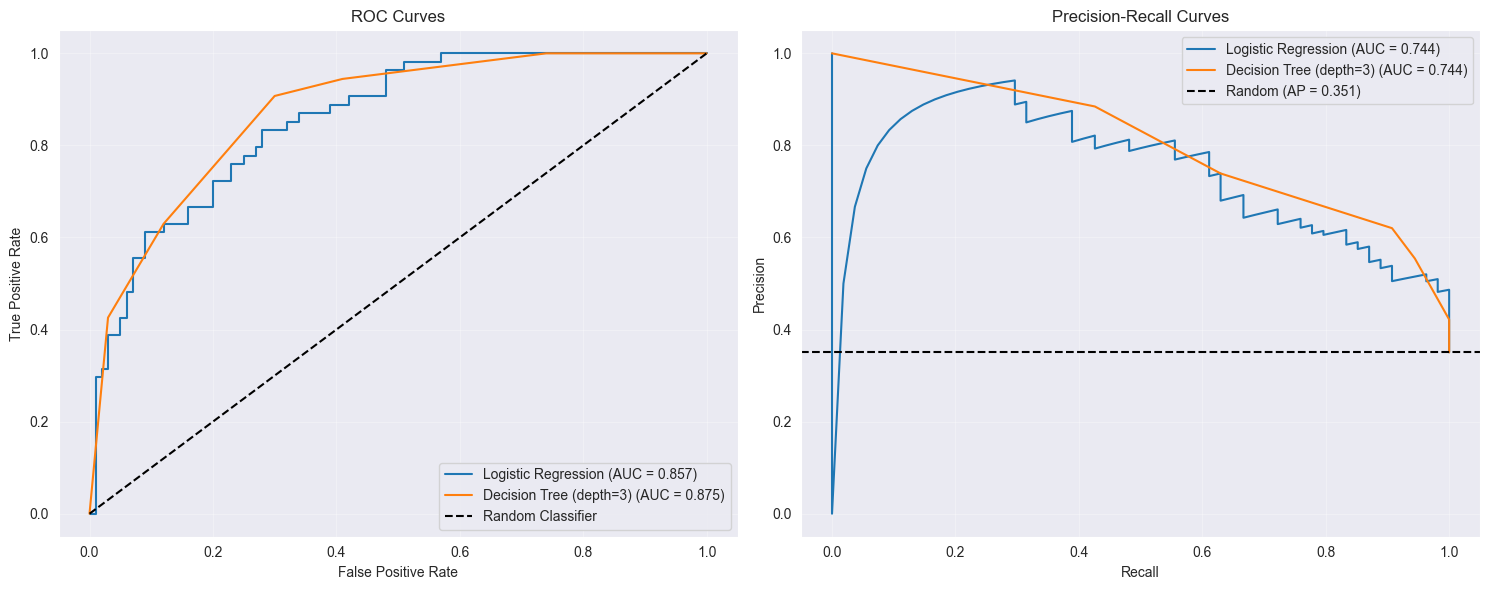

In [12]:
# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ ROC –∏ PR –∫—Ä–∏–≤—ã—Ö –¥–ª—è –æ–±–µ–∏—Ö –º–æ–¥–µ–ª–µ–π
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC –∫—Ä–∏–≤—ã–µ
for model_name, metrics in metrics_comparison.items():
    fpr, tpr, _ = roc_curve(y_valid, metrics['y_pred_proba'])
    roc_auc = metrics['roc_auc']
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PR –∫—Ä–∏–≤—ã–µ
for model_name, metrics in metrics_comparison.items():
    precision, recall, _ = precision_recall_curve(y_valid, metrics['y_pred_proba'])
    pr_auc = metrics['pr_auc']
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.3f})')

# –ë–∞–∑–æ–≤–∞—è PR –∫—Ä–∏–≤–∞—è –¥–ª—è —Å–ª—É—á–∞–π–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
baseline = len(y_valid[y_valid==1]) / len(y_valid)
ax2.axhline(y=baseline, color='k', linestyle='--', label=f'Random (AP = {baseline:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

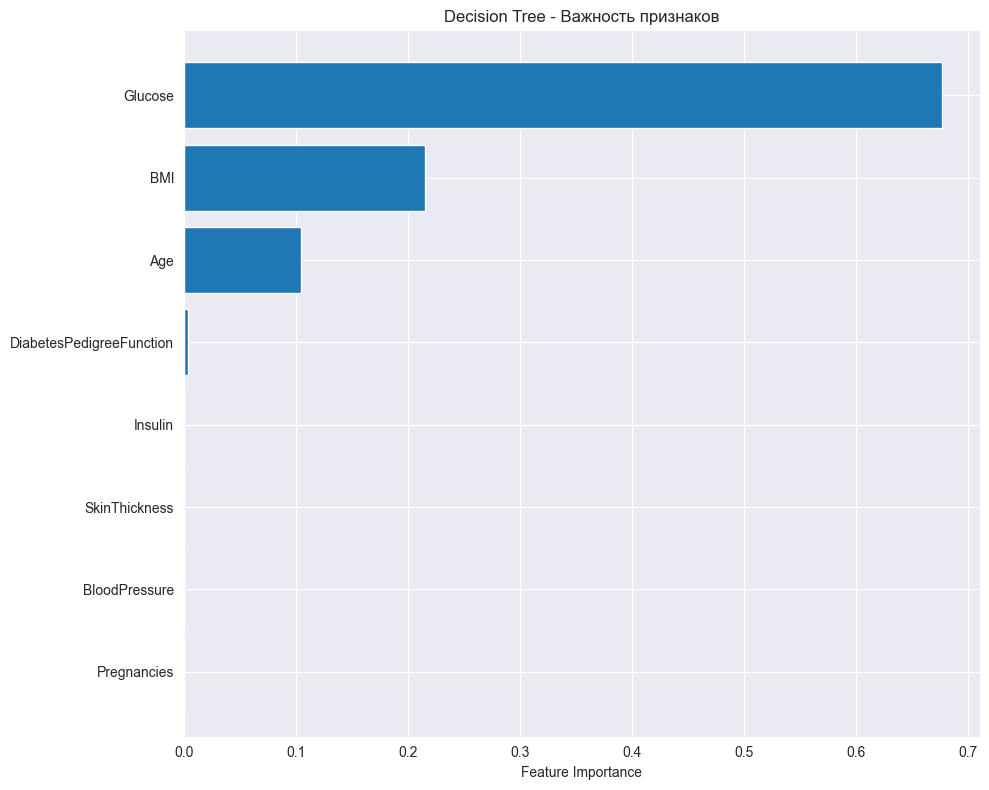

–¢–æ–ø-5 —Å–∞–º—ã—Ö –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–µ—Ä—Å–∏–∏ Decision Tree:
                    feature  importance
1                   Glucose    0.676511
5                       BMI    0.214774
7                       Age    0.104579
6  DiabetesPedigreeFunction    0.004136
4                   Insulin    0.000000


In [13]:
# –ê–Ω–∞–ª–∏–∑ –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ Decision Tree
if hasattr(dt_best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_importance = dt_best_pipeline.named_steps['classifier'].feature_importances_
    
    # –°–æ–∑–¥–∞–Ω–∏–µ DataFrame –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –≤–∞–∂–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Decision Tree - –í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
    plt.tight_layout()
    plt.show()
    
    print("–¢–æ–ø-5 —Å–∞–º—ã—Ö –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –≤–µ—Ä—Å–∏–∏ Decision Tree:")
    print(importance_df.tail(5).sort_values('importance', ascending=False))

In [15]:
# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
best_model_name = None
best_f1 = 0

for model_name, metrics in metrics_comparison.items():
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_model_name = model_name

print("=" * 60)
print("–í–´–ë–û–† –õ–£–ß–®–ï–ô BASELINE –ú–û–î–ï–õ–ò")
print("=" * 60)
print(f"üèÜ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: {best_model_name}")
print(f"üìä –õ—É—á—à–∏–π F1 Score: {best_f1:.4f}")

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
if 'Logistic Regression' in best_model_name:
    best_baseline_model = lr_pipeline
else:
    best_baseline_model = dt_best_pipeline

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –¥–ª—è —Å–ª–µ–¥—É—é—â–∏—Ö —É—á–∞—Å—Ç–Ω–∏–∫–æ–≤
baseline_results = {
    'logistic_regression': {
        'model': lr_pipeline,
        'metrics': lr_metrics
    },
    'decision_tree': {
        'model': dt_best_pipeline, 
        'metrics': dt_metrics
    },
    'best_baseline': {
        'model': best_baseline_model,
        'name': best_model_name,
        'metrics': metrics_comparison[best_model_name]
    },
    'comparison': metrics_comparison
}

with open('../data/interim/baseline_models_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print(f"‚úÖ –õ—É—á—à–∞—è baseline –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: {best_model_name}")

–í–´–ë–û–† –õ–£–ß–®–ï–ô BASELINE –ú–û–î–ï–õ–ò
üèÜ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: Decision Tree (depth=3)
üìä –õ—É—á—à–∏–π F1 Score: 0.7368
‚úÖ –õ—É—á—à–∞—è baseline –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞: Decision Tree (depth=3)


In [16]:
print("=" * 60)
print("–û–¢–ß–ï–¢ –£–ß–ê–°–¢–ù–ò–ö–ê 2: –ë–ê–ó–û–í–´–ï –ú–û–î–ï–õ–ò")
print("=" * 60)

print("\n‚úÖ –í–´–ü–û–õ–ù–ï–ù–ù–´–ï –ó–ê–î–ê–ß–ò:")
print("1. –û–±—É—á–µ–Ω–∞ Logistic Regression —Å —É—á–µ—Ç–æ–º –¥–∏—Å–±–∞–ª–∞–Ω—Å–∞ –∫–ª–∞—Å—Å–æ–≤")
print("2. –û–±—É—á–µ–Ω Decision Tree Classifier —Å –ø–æ–¥–±–æ—Ä–æ–º max_depth")
print("3. –†–∞—Å—Å—á–∏—Ç–∞–Ω—ã –º–µ—Ç—Ä–∏–∫–∏ –Ω–∞ valid: F1, ROC-AUC, PR-AUC")
print("4. –ü—Ä–æ–≤–µ–¥–µ–Ω–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π –∏ –≤—ã–±–æ—Ä –ª—É—á—à–µ–π baseline")

print("\nüìä –†–ï–ó–£–õ–¨–¢–ê–¢–´ –ù–ê VALIDATION SET:")
print(comparison_df.to_string(index=False))

print(f"\nüéØ –í–´–í–û–î–´:")
print(f"- –õ—É—á—à–∞—è baseline –º–æ–¥–µ–ª—å: {best_model_name}")
print(f"- –õ—É—á—à–∏–π F1 Score: {best_f1:.4f}")

if 'Logistic Regression' in best_model_name:
    print("- Logistic Regression –ø–æ–∫–∞–∑–∞–ª–∞ –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –±–ª–∞–≥–æ–¥–∞—Ä—è:")
    print("  * –õ—É—á—à–µ–π –æ–±–æ–±—â–∞—é—â–µ–π —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏")
    print("  * –ú–µ–Ω—å—à–µ–π —Å–∫–ª–æ–Ω–Ω–æ—Å—Ç–∏ –∫ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—é")
    print("  * –ë–æ–ª–µ–µ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º")
else:
    print("- Decision Tree –ø–æ–∫–∞–∑–∞–ª –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –±–ª–∞–≥–æ–¥–∞—Ä—è:")
    print("  * –°–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏ —É–ª–∞–≤–ª–∏–≤–∞—Ç—å –Ω–µ–ª–∏–Ω–µ–π–Ω—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏") 
    print("  * –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–º—É –≤—ã–±–æ—Ä—É –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤")

print(f"\nüìà –ö–ê–ß–ï–°–¢–í–û –ú–û–î–ï–õ–ï–ô:")
print(f"- ROC-AUC –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏: {metrics_comparison[best_model_name]['roc_auc']:.4f}")
print(f"- PR-AUC –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏: {metrics_comparison[best_model_name]['pr_auc']:.4f}")

print(f"\nüíæ –°–û–•–†–ê–ù–ï–ù–ù–´–ï –†–ï–ó–£–õ–¨–¢–ê–¢–´:")
print("1. baseline_models_results.pkl - –≤—Å–µ –º–æ–¥–µ–ª–∏ –∏ –º–µ—Ç—Ä–∏–∫–∏")
print("2. –õ—É—á—à–∞—è baseline –º–æ–¥–µ–ª—å –≥–æ—Ç–æ–≤–∞ –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è —Å –ø—Ä–æ–¥–≤–∏–Ω—É—Ç—ã–º–∏ –º–æ–¥–µ–ª—è–º–∏")

print(f"\n‚û°Ô∏è –î–ê–õ–¨–ù–ï–ô–®–ò–ï –î–ï–ô–°–¢–í–ò–Ø:")
print("–£—á–∞—Å—Ç–Ω–∏–∫ 3 –º–æ–∂–µ—Ç –ø—Ä–∏—Å—Ç—É–ø–∞—Ç—å –∫ –æ–±—É—á–µ–Ω–∏—é –ø—Ä–æ–¥–≤–∏–Ω—É—Ç—ã—Ö –º–æ–¥–µ–ª–µ–π (CatBoost/LightGBM/XGBoost)")
print("–∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é –∏—Ö —Å –≤—ã–±—Ä–∞–Ω–Ω–æ–π baseline –º–æ–¥–µ–ª—å—é.")

–û–¢–ß–ï–¢ –£–ß–ê–°–¢–ù–ò–ö–ê 2: –ë–ê–ó–û–í–´–ï –ú–û–î–ï–õ–ò

‚úÖ –í–´–ü–û–õ–ù–ï–ù–ù–´–ï –ó–ê–î–ê–ß–ò:
1. –û–±—É—á–µ–Ω–∞ Logistic Regression —Å —É—á–µ—Ç–æ–º –¥–∏—Å–±–∞–ª–∞–Ω—Å–∞ –∫–ª–∞—Å—Å–æ–≤
2. –û–±—É—á–µ–Ω Decision Tree Classifier —Å –ø–æ–¥–±–æ—Ä–æ–º max_depth
3. –†–∞—Å—Å—á–∏—Ç–∞–Ω—ã –º–µ—Ç—Ä–∏–∫–∏ –Ω–∞ valid: F1, ROC-AUC, PR-AUC
4. –ü—Ä–æ–≤–µ–¥–µ–Ω–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π –∏ –≤—ã–±–æ—Ä –ª—É—á—à–µ–π baseline

üìä –†–ï–ó–£–õ–¨–¢–ê–¢–´ –ù–ê VALIDATION SET:
                  Model  F1 Score  ROC-AUC   PR-AUC
    Logistic Regression  0.654545 0.857407 0.743635
Decision Tree (depth=3)  0.736842 0.874907 0.743606

üéØ –í–´–í–û–î–´:
- –õ—É—á—à–∞—è baseline –º–æ–¥–µ–ª—å: Decision Tree (depth=3)
- –õ—É—á—à–∏–π F1 Score: 0.7368
- Decision Tree –ø–æ–∫–∞–∑–∞–ª –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –±–ª–∞–≥–æ–¥–∞—Ä—è:
  * –°–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏ —É–ª–∞–≤–ª–∏–≤–∞—Ç—å –Ω–µ–ª–∏–Ω–µ–π–Ω—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏
  * –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–º—É –≤—ã–±–æ—Ä—É –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–